### ohne hems


In [18]:
import pandas as pd
import importlib
import berechnen_wp, pv_profil, lastprofile_VDI4655, temperatur_aussen, try_region, heizkurve
importlib.reload(berechnen_wp)
importlib.reload(lastprofile_VDI4655)

h, w, twe, s = lastprofile_VDI4655.get_jahresenergiebedarf('1958 - 1968', 200, 3, 0)
TRY_region, T_n_aussen = try_region.get_try_t_n_aussen(40599)
df = lastprofile_VDI4655.get_lastprofile(w, 4000, twe, 200, TRY_region, 3)
df['T_aussen'] = temperatur_aussen.get_hourly_temperature(40599, 2014)
hz, T_soll, T_n_vor, T_n_rueck = heizkurve.get_heizkurve('Heizkörper', df['T_aussen'], T_n_aussen)
df['T_vor'] = hz['T_vor']
# df['T_rueck'] = hz['T_rueck']
wp_groesse, wp_modell = berechnen_wp.get_waermepumpe(h)
heizleistung_auslegung = heizkurve.get_heizleistung(T_n_aussen, h, T_soll)
# df = heizkurve.get_heizleistung_profil(df, heizleistung_auslegung)
df = heizkurve.get_cop(wp_groesse, df)
V_ps, PS_verlust, Q_ps, Q_ps_max, Q_ps_ueber = berechnen_wp.get_pufferspeicher(h, T_n_vor, T_n_rueck)
pv = pv_profil.get_pv_profil(40599, 2014, 10)

In [19]:
importlib.reload(berechnen_wp)
df_wp = berechnen_wp.get_max_heizleistung(wp_groesse, df.copy())

In [4]:
importlib.reload(berechnen_wp)
df_ohne = berechnen_wp.ohne_pv(df_wp.copy(), Q_ps, Q_ps_max, PS_verlust)

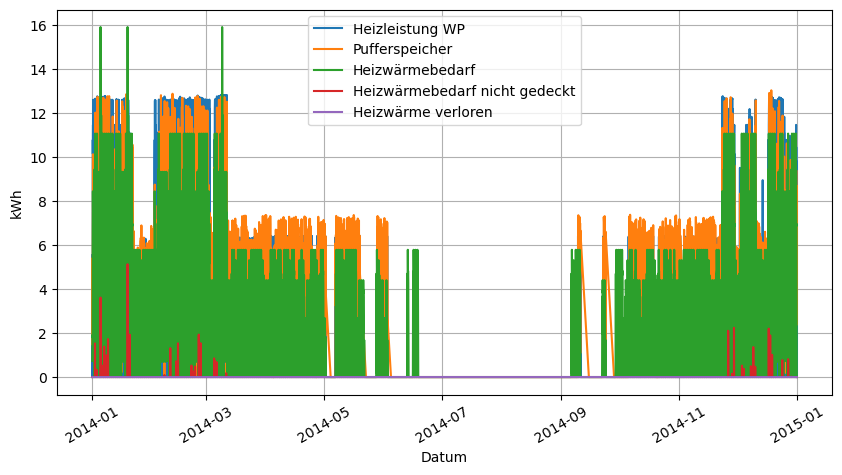

In [204]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

#plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_ohne.index, df_ohne['Heizleistung WP'], label = "Heizleistung WP")  
#plt.plot(df_ohne.index, df_ohne['Heizleistung'], label = "Heizleistung") 
plt.plot(df_ohne.index, df_ohne['Wärmegehalt PS'], label = "Pufferspeicher")  
plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_ohne.index, df_ohne['Deckung'], label = "Heizwärmebedarf nicht gedeckt") 
plt.plot(df_ohne.index, df_ohne['Verlust'], label = "Heizwärme verloren")
#plt.plot(df_ohne.index, df_ohne['State'], label = "State")
#plt.plot(df_ohne.index, df_ohne['temp_mittel'], label = "Mittlere Temperatur (48h)")
#plt.plot(df_ohne.index, df_ohne['wärmebedarf_mittel'], label = "Mittlere Wärmebedarf (3h)")

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')
plt.grid(visible=True)
plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-01 00:00:00'), pd.Timestamp('2014-01-03 23:00:00')) 
plt.show()

In [205]:
print(df_ohne['Strombedarf WP'].sum())
print(df_ohne['Deckung'].sum())
print(df_ohne['Verlust'].sum())


5052.090363235122
55.076172923143695
0.0


### alte WP Berechnung ohne_pv_alt

In [116]:
importlib.reload(berechnen_wp)
df_1, P_el, COP = berechnen_wp.ohne_pv_alt(df_wp.copy(), Q_ps, PS_verlust)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




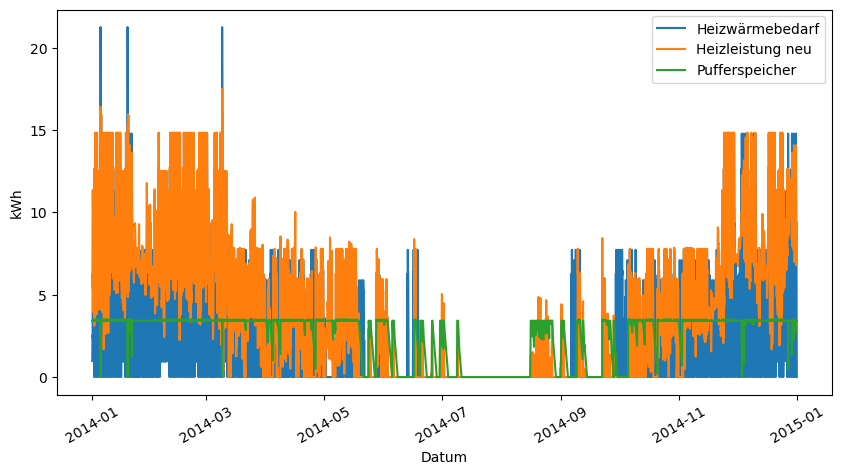

In [117]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

plt.plot(df_1.index, df_1['Heizwärmebedarf'], label = "Heizwärmebedarf")
plt.plot(df_1.index, df_1['Heizleistung neu'], label = "Heizleistung neu")  
# plt.plot(df_1.index, df_1['Heizleistung'], label = "Heizleistung") 
plt.plot(df_1.index, df_1['Wärmegehalt PS'], label = "Pufferspeicher")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-10 00:00:00'), pd.Timestamp('2014-01-13 23:00:00')) 
plt.show()

### mit PV, BS, EV

In [99]:
importlib.reload(berechnen_wp)
pv = pv_profil.get_pv_profil(40599, 2014, 10)
df_pv = berechnen_wp.mit_pv(df_ohne.copy(), pv)
df_pvbs = berechnen_wp.mit_pvbs(df_ohne.copy(), pv, 10, 11)

In [100]:
importlib.reload(berechnen_wp)
strompreis = 0.358
ergebnisse_pv = berechnen_wp.ersparnis_pv(df_pv, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_pv)

Haushaltsstrombedarf in kWh: 4001
Wärmepumpe Strombedarf in kWh: 6657
Jahresertrag in kWh: 11282
Eigenverbrauch in kWh: 3324
Geladene PV-Strom in Wärmepumpe in kWh: 1691

Netzbezug in kWh: 5643
Einspeisung ins Netz in kWh: 7958

Stromkosten ohne PV in €/a: 3815.56
Stromkosten mit PV in €/a: 2020.19
Einspeisevergütung in €/a: 633.46
Stromkosten Einsparung in €/a: 2428.83


In [101]:
importlib.reload(berechnen_wp)
ergebnisse_bs = berechnen_wp.ersparnis_bs(df_pvbs, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_bs)

Haushaltsstrombedarf in kWh: 4001
Wärmepumpe Strombedarf in kWh: 6657
Jahresertrag in kWh: 11282
Eigenverbrauch in kWh: 5431
Geladene PV-Strom in Wärmepumpe in kWh: 1691
Geladene PV-Strom in Batteriespeicher in kWh: 2023
Geladene BS-Strom in Wärmepumoe in kWh: 647

Netzbezug in kWh: 5389
Einspeisung ins Netz in kWh: 5851

Stromkosten ohne PV in €/a: 3815.56
Stromkosten mit PV & BS in €/a: 1929.26
Einspeisevergütung in €/a: 465.74
Stromkosten Einsparung in €/a: 2352.04


In [105]:
importlib.reload(berechnen_wp)
df_ev = berechnen_wp.mit_pvev(df_ohne.copy(), pv, True)

In [107]:
importlib.reload(berechnen_wp)
df_pvbsev = berechnen_wp.mit_pvbsev(df_ohne.copy(), pv, 10, 11, True)

In [109]:
importlib.reload(berechnen_wp)
ergebnisse_ev = berechnen_wp.ersparnis_ev(df_ev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_ev)

Haushaltsstrombedarf in kWh: 4001
Wärmepumpe Strombedarf in kWh: 6657
EV Strombedarf in kWh: 1996
Jahresertrag in kWh: 11282
Eigenverbrauch in kWh: 3559
Geladene PV-Strom in Wärmepumpe in kWh: 1691
Geladene PV-Strom in Elektroauto in kWh: 235

Netzbezug in kWh: 9095
Einspeisung ins Netz in kWh: 7723

Stromkosten ohne PV in €/a: 4530.13
Stromkosten mit PV & EV in €/a: 3256.01
Einspeisevergütung in €/a: 614.75
Stromkosten Einsparung in €/a: 1888.87


In [110]:
importlib.reload(berechnen_wp)
ergebnisse_evbs = berechnen_wp.ersparnis_evbs(df_pvbsev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_evbs)

Haushaltsstrombedarf in kWh: 4001
Wärmepumpe Strombedarf in kWh: 6657
EV Strombedarf in kWh: 1996
Jahresertrag in kWh: 11282
Eigenverbrauch in kWh: 6018
Geladene PV-Strom in Wärmepumpe in kWh: 1691
Geladene PV-Strom in Batteriespeicher in kWh: 2451
Geladene PV-Strom in Elektroauto in kWh: 141
Geladene BS-Strom in Elektroauto in kWh: 756
Geladene BS-Strom in Wärmepumoe in kWh: 705

Netzbezug in kWh: 6832
Einspeisung ins Netz in kWh: 5264

Stromkosten ohne PV in €/a: 4530.13
Stromkosten mit PV, BS & EV in €/a: 2445.86
Einspeisevergütung in €/a: 419.01
Stromkosten Einsparung in €/a: 2503.28


## mit HEMS

In [20]:
importlib.reload(berechnen_wp)
df_hems, df_o_hems = berechnen_wp.mit_hems(df_wp.copy(), pv, Q_ps, Q_ps_max, Q_ps_ueber, PS_verlust)

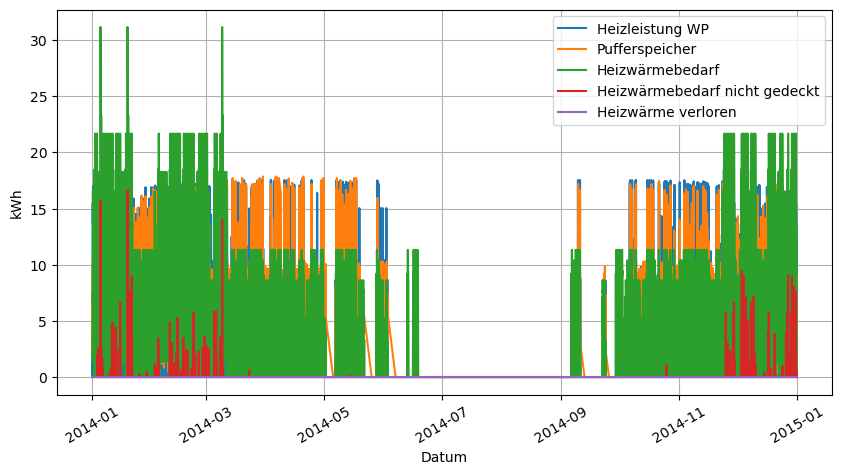

In [21]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

#plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_hems.index, df_hems['Heizleistung WP'], label = "Heizleistung WP")  
#plt.plot(df_ohne.index, df_hems['PV Ertrag'], label = "PV") 
plt.plot(df_hems.index, df_hems['Wärmegehalt PS'], label = "Pufferspeicher")  
plt.plot(df_hems.index, df_hems['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_hems.index, df_hems['Deckung'], label = "Heizwärmebedarf nicht gedeckt") 
plt.plot(df_hems.index, df_hems['Verlust'], label = "Heizwärme verloren")
#plt.plot(df_hems.index, df_hems['State'], label = "State")
#plt.plot(df_ohne.index, df_ohne['temp_mittel'], label = "Mittlere Temperatur (48h)")
#plt.plot(df_ohne.index, df_ohne['wärmebedarf_mittel'], label = "Mittlere Wärmebedarf (3h)")

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')
plt.grid(visible=True)
plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-01 00:00:00'), pd.Timestamp('2014-01-01 23:00:00')) 
plt.show()

In [22]:
print(df_hems['Deckung'].sum())
print(df_hems['Verlust'].sum())
print(df_hems['Strombedarf WP'].sum())

897.8982854552594
0.0
9389.542234800967


In [ ]:
importlib.reload(berechnen_wp)
ergebnisse = berechnen_wp.ersparnis_hems(df_hems, df_o_hems, 10, 0.358)
berechnen_wp.print_ersparnis_hems(ergebnisse)



Haushaltsstrombedarf in kWh: 4001
Jahresertrag in kWh: 11282

Ohne HEMS
Geladene PV-Strom in Wärmepumpe in kWh: 1416
Wärmepumpe Strombedarf in kWh: 5052
Netzbezug in kWh: 6005
Stromkosten mit in €/a: 2149.79
Einspeisung ins Netz in kWh: 8234
Einspeisevergütung in €/a: 655.43
Eigenverbrauch in kWh: 3048
kg CO₂/a: 2.28

Mit HEMS
Geladene PV-Strom in Wärmepumpe in kWh: 1467
Wärmepumpe Strombedarf in kWh: 5057
Netzbezug in kWh: 5959
Stromkosten mit in €/a: 2133.32
Einspeisung ins Netz in kWh: 8183
Einspeisevergütung in €/a: 651.37
Eigenverbrauch in kWh: 3099
kg CO₂/a: 2.26

Stromkosten Einsparung in €/a: 12.41
CO2 Einsparung kg CO₂/a: 0.02


### HEMS & BS

In [27]:
importlib.reload(berechnen_wp)
df_hems_bs, df_ohne_bs = berechnen_wp.mit_hems_bs(df_hems.copy(), df_ohne.copy(), pv, 10, 10)

In [34]:
importlib.reload(berechnen_wp)
ergebnisse = berechnen_wp.ersparnis_hems_bs(df_hems_bs, df_ohne_bs, 10, 0.358)
berechnen_wp.print_ersparnis_hems(ergebnisse)


Haushaltsstrombedarf in kWh: 4001
Jahresertrag in kWh: 11282

Ohne HEMS
Wärmepumpe Strombedarf in kWh: 5052
Geladene PV-Strom in Wärmepumpe in kWh: 1416
Geladene PV-Strom in Batteriespeicher in kWh: 1974
Geladene BS-Strom in Wärmepumpe in kWh: 585
Netzbezug in kWh: 4106
Stromkosten in €/a: 1469.95
Einspeisung ins Netz in kWh: 6178
Einspeisevergütung in €/a: 491.77
Eigenverbrauch in kWh: 5104
kg CO₂/a: 1.56

Mit HEMS
Wärmepumpe Strombedarf in kWh: 5057
Geladene PV-Strom in Wärmepumpe in kWh: 1467
Geladene PV-Strom in Batteriespeicher in kWh: 1949
Geladene BS-Strom in Wärmepumpe in kWh: 580
Netzbezug in kWh: 4084
Stromkosten in €/a: 1462.07
Einspeisung ins Netz in kWh: 6153
Einspeisevergütung in €/a: 489.78
Eigenverbrauch in kWh: 5129
kg CO₂/a: 1.55

Stromkosten Einsparung in €/a: 5.89
CO2 Einsparung kg CO₂/a: 0.01


### HEMS & EV

In [39]:
importlib.reload(berechnen_wp)
df_hems_ev, df_ohne_ev = berechnen_wp.mit_hems_ev(df_hems.copy(), df_ohne.copy(), pv, homeoffice = True)

In [40]:
importlib.reload(berechnen_wp)
ergebnisse = berechnen_wp.ersparnis_hems_ev(df_hems_ev, df_ohne_ev, 10, 0.358)
berechnen_wp.print_ersparnis_hems(ergebnisse)

Haushaltsstrombedarf in kWh: 4001
Jahresertrag in kWh: 11282

Ohne HEMS
Wärmepumpe Strombedarf in kWh: 5052
EV Strombedarf in kWh: 1996
Geladene PV-Strom in Wärmepumpe in kWh: 1416
Geladene PV-Strom in Elektroauto in kWh: 242

Netzbezug in kWh: 7759
Stromkosten in €/a: 2777.72
Einspeisung ins Netz in kWh: 7992
Einspeisevergütung in €/a: 636.16
Eigenverbrauch in kWh: 3290
kg CO₂/a: 2.95

Mit HEMS
Wärmepumpe Strombedarf in kWh: 5057
EV Strombedarf in kWh: 1967
Geladene PV-Strom in Wärmepumpe in kWh: 1467
Geladene PV-Strom in Elektroauto in kWh: 1691

Netzbezug in kWh: 6234
Stromkosten in €/a: 2231.77
Einspeisung ins Netz in kWh: 6491
Einspeisevergütung in €/a: 516.68
Eigenverbrauch in kWh: 4791
kg CO₂/a: 2.37

Stromkosten Einsparung in €/a: 426.47
CO2 Einsparung kg CO₂/a: 0.58


### HEMS + BS + EV

In [41]:
importlib.reload(berechnen_wp)
df_hems_bsev, df_ohne_bsev = berechnen_wp.mit_hems_bsev(df_hems.copy(), df_ohne.copy(), pv, 10, 10, homeoffice = True)

In [45]:
importlib.reload(berechnen_wp)
ergebnisse = berechnen_wp.ersparnis_hems_bsev(df_hems_bsev, df_ohne_bsev, 10, 0.358)
berechnen_wp.print_ersparnis_hems(ergebnisse)

Haushaltsstrombedarf in kWh: 4001
Jahresertrag in kWh: 11282

Ohne HEMS
Wärmepumpe Strombedarf in kWh: 5052
EV Strombedarf in kWh: 1996

Geladene PV-Strom in Wärmepumpe in kWh: 1416
Geladene PV-Strom in Batteriespeicher in kWh: 2364
Geladene PV-Strom in Elektroauto in kWh: 151

Geladene BS-Strom in Wärmepumpe in kWh: 593
Geladene BS-Strom in Elektroauto in kWh: 762

Netzbezug in kWh: 5576
Stromkosten in €/a: 1996.21
Einspeisung ins Netz in kWh: 5620
Einspeisevergütung in €/a: 447.35
Eigenverbrauch in kWh: 5662
kg CO₂/a: 2118.88

Mit HEMS
Wärmepumpe Strombedarf in kWh: 5057
EV Strombedarf in kWh: 1954

Geladene PV-Strom in Wärmepumpe in kWh: 1467
Geladene PV-Strom in Batteriespeicher in kWh: 1968
Geladene PV-Strom in Elektroauto in kWh: 1369

Geladene BS-Strom in Wärmepumpe in kWh: 650
Geladene BS-Strom in Elektroauto in kWh: 79

Netzbezug in kWh: 4652
Stromkosten in €/a: 1665.42
Einspeisung ins Netz in kWh: 4765
Einspeisevergütung in €/a: 379.29
Eigenverbrauch in kWh: 5247
kg CO₂/a: 17

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

monat = 7
plot_data = ['PV Ertrag', 'Strombedarf', 'einspeisung', 'netzbezug', 'Strombedarf WP']
tag = df_hems_bsev.loc[f'2014-{monat:02d}-01 00:00:00':f'2014-{monat:02d}-01 23:00:00', plot_data]

data_2 = ['BS %', "EV %"]
tag_2 = df_hems_bsev.loc[f'2014-{monat:02d}-01 00:00:00':f'2014-{monat:02d}-01 23:00:00', data_2]

# Add traces for primary axis
for col in plot_data:
    fig.add_trace(
        go.Scatter(x=tag.index, y=tag[col], name=col),
        secondary_y=False,
    )

# Add traces for secondary axis
for col in data_2:
    fig.add_trace(
        go.Scatter(x=tag_2.index, y=tag_2[col], name=col, line=dict(dash='dot')),
        secondary_y=True,
    )

# Set x-axis title
fig.update_xaxes(title_text="Zeit")

# Set y-axes titles
fig.update_yaxes(title_text="kWh", secondary_y=False)
fig.update_yaxes(title_text="SOC %", secondary_y=True)


# Update layout to move legend below the graph
fig.update_layout(
    legend=dict(
        orientation="h",  # Horizontal alignment
        yanchor="top",
        y=-0.2,  # Move legend below the graph
        xanchor="center",
        x=0.5  # Center the legend
    )
)

# Show figure
fig.show()


In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

monat = 8
plot_data = ['PV Ertrag', 'Strombedarf', 'einspeisung', 'netzbezug', 'Strombedarf WP']
tag = df_hems_bsev.loc[f'2014-{monat:02d}-01 00:00:00':f'2014-{monat:02d}-01 23:00:00', plot_data]

data_2 = ['BS %', "EV %"]
tag_2 = df_hems_bsev.loc[f'2014-{monat:02d}-01 00:00:00':f'2014-{monat:02d}-01 23:00:00', data_2]

# Add traces for primary axis with filled areas
for col in plot_data:
    fig.add_trace(
        go.Scatter(
            x=tag.index, 
            y=tag[col], 
            name=col, 
            fill='tozeroy',  # Füllt die Fläche unter der Linie
            mode='lines',
            line=dict(width=1.5)  # Linienbreite anpassen
        ),
        secondary_y=False,
    )

# Add traces for secondary axis (diese Linien bleiben ohne Füllung)
for col in data_2:
    fig.add_trace(
        go.Scatter(
            x=tag_2.index, 
            y=tag_2[col], 
            name=col, 
            mode='lines', 
            line=dict(dash='dot', width=2)  # Gestrichelte Linien für Sekundärachse
        ),
        secondary_y=True,
    )

# Set x-axis title
fig.update_xaxes(title_text="Zeit")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> kWh", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> SOC %", secondary_y=True)

# Show figure
fig.show()


In [68]:
# # Jahresdiagramm: Einsparung pro Woche im Jahr, als Balken vlt
anlage_groesse = 10
strompreis = 0.358
# Einsparung pro Woche
# Stromkosten
df_hems_bsev['Stromkosten'] = df_hems_bsev['netzbezug']*strompreis
df_ohne_bsev['Stromkosten'] = df_ohne_bsev['netzbezug']*strompreis
# Einspeisevergütung 
if anlage_groesse <= 10:
        einspeiseverguetung = 0.0796
else:
        einspeiseverguetung = 0.0689 
df_hems_bsev['Einspeisevergütung'] = df_hems_bsev['einspeisung'] * einspeiseverguetung
df_ohne_bsev['Einspeisevergütung'] = df_ohne_bsev['einspeisung'] * einspeiseverguetung
# Einsparung
df_hems_bsev['Einsparung'] = (df_ohne_bsev['Stromkosten'] - df_ohne_bsev['Einspeisevergütung']) - (df_hems_bsev['Stromkosten']-df_hems_bsev['Einspeisevergütung'])


In [73]:
import plotly.express as px
import pandas as pd

# Kalenderwoche aus dem Zeitindex extrahieren
df_hems_bsev['KW'] = df_hems_bsev.index.to_series().dt.isocalendar().week

# Einsparung pro Kalenderwoche aggregieren (Summe der Stundenwerte pro KW) und auf 2 Nachkommastellen runden
df_kw = df_hems_bsev.groupby('KW')['Einsparung'].sum().round(2).reset_index()

# Erstelle das Balkendiagramm mit Plotly Express
fig = px.bar(df_kw, x="KW", y="Einsparung", text=df_kw['Einsparung'].apply(lambda x: f"{x:.2f}"), 
             labels={"KW": "Kalenderwoche", "Einsparung": "Einsparung (€)"})

# Automatische Textanzeige auf den Balken aktivieren
fig.update_traces(textposition='outside')

# Layout-Anpassungen
fig.update_layout(title="Einsparung pro Kalenderwoche (2014)", xaxis=dict(tickmode="linear"))

# Diagramm anzeigen
fig.show()

